In [9]:
# Install the Kaggle library
!pip install -q kaggle

# Use Colab's file uploader
from google.colab import files
print("Please upload the kaggle.json file you downloaded from your Kaggle account.")
files.upload()

# Create a directory for the Kaggle API configuration
!mkdir -p ~/.kaggle
# Move the uploaded kaggle.json to the required directory
!cp kaggle.json ~/.kaggle/
# Set the correct permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API configured successfully.")

Please upload the kaggle.json file you downloaded from your Kaggle account.


Saving kaggle.json to kaggle.json

Kaggle API configured successfully.


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import kagglehub
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Set plot style
sns.set_style('whitegrid')

In [91]:
# Download the dataset using the Kaggle Hub API
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [92]:
# Initial inspection
print("Dataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isna().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

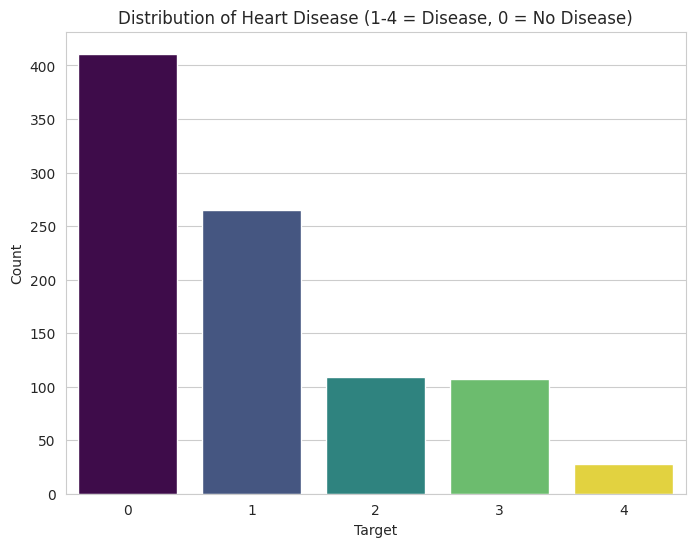

In [95]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1-4 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

**Insight:**
- 1.  The dataset is considered to be balanced, between disease (1-4) and no disease. This shows our model will have a similar number of examples for both classes.

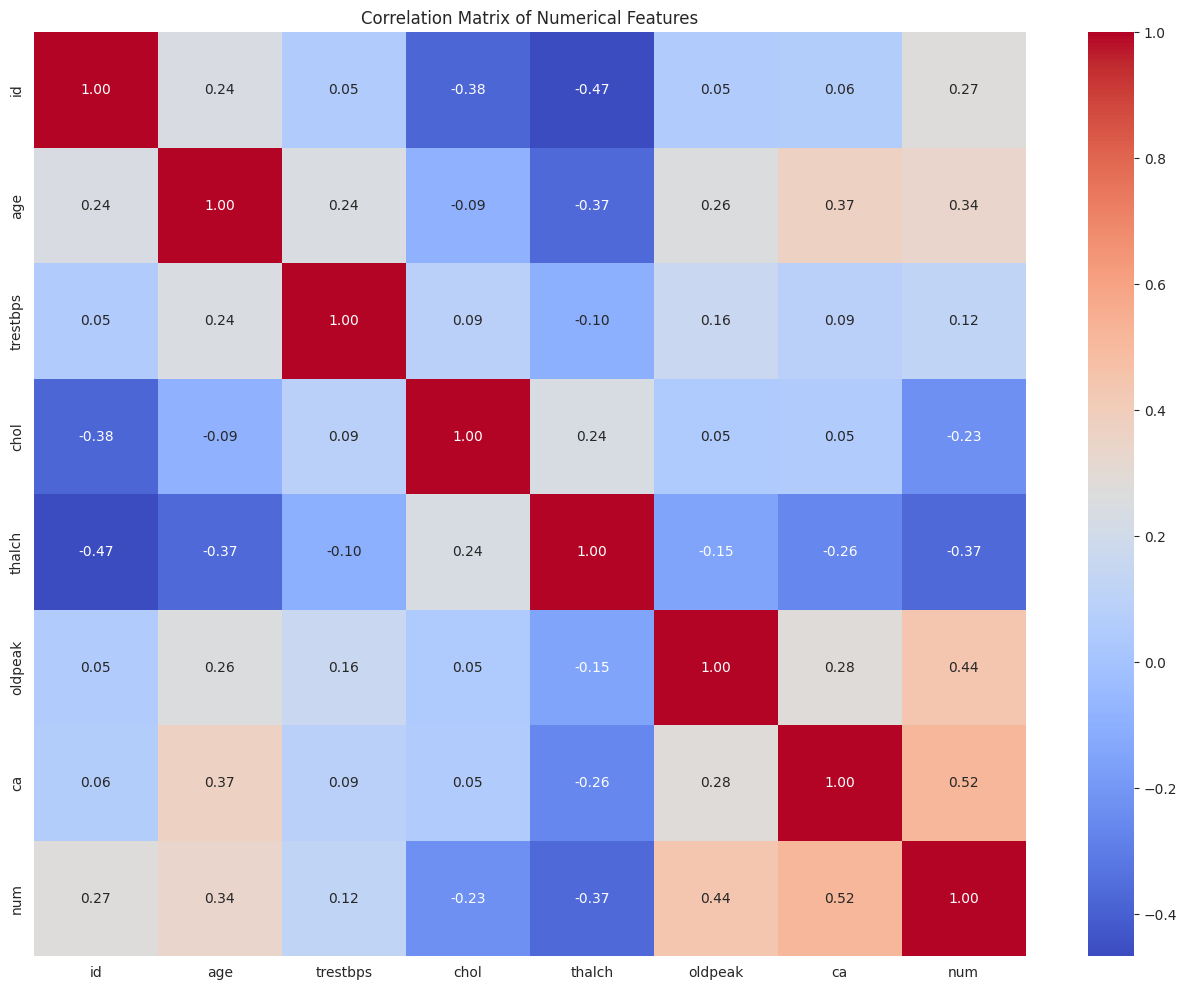

In [96]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Model building, training and evaluation

In [97]:
# Define features (X) and target (y)
X = df.drop('num', axis=1)
y = df['num']

# Drop the 'id' and 'dataset' columns as they are not features
X = X.drop(['id', 'dataset'], axis=1)


# Identify categorical and numerical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

In [98]:
print(f"Training data shape: {X.shape}")
print(f"Testing data shape: {y.shape}")

Training data shape: (920, 13)
Testing data shape: (920,)


In [103]:
missing_data = X.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

print("Features with missing values:")
print(missing_data)

Features with missing values:
Series([], dtype: int64)


In [106]:
# Impute numerical features with mode
numerical_cols_to_impute_mode = ['thal', 'slope', 'fbs', 'exang', 'restecg']
for col in numerical_cols_to_impute_mode:
    if col in X.columns:
        X[col] = X[col].fillna(X[col].mode()[0]).infer_objects(copy=False)

In [105]:
# Impute numerical features with median
numerical_cols_to_impute_median = ['ca', 'oldpeak', 'trestbps', 'thalch', 'chol']
for col in numerical_cols_to_impute_median:
    if col in X.columns:
        X[col] = X[col].fillna(X[col].median())

In [107]:
# Convert any remaining object columns to category type for one-hot encoding
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Data shape after encoding: {X.shape}")

Data shape after encoding: (920, 18)


In [108]:
# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X)

### Logistic Regression for classification

In [110]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

In [111]:
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr, zero_division=0))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.43      0.48      0.45        82
           1       0.30      0.40      0.34        53
           2       0.22      0.09      0.13        22
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00         6

    accuracy                           0.34       184
   macro avg       0.19      0.19      0.18       184
weighted avg       0.30      0.34      0.31       184



In [112]:
# Create the submission DataFrame
submission = pd.DataFrame({'Id': y.index, 'num': y})

# Save to csv
submission.to_csv('L4_submission.csv', index=False)

print("Submission file 'L4_submission.csv' created successfully.")
submission.head()

Submission file 'L4_submission.csv' created successfully.


,Id,num
0,0,0
1,1,2
2,2,1
3,3,0
4,4,0


In [113]:
from google.colab import files
files.download('L4_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Conclusion**

---



---



---



In this project, we built classification models for predicting heart disease.

**Key Steps**
1.  **Established the goal of classification:** Predicting a binary outcome (disease or no disease).
2.  **Performed a thorough EDA:** Identified key medical indicators like chest pain type, max heart rate, and `ca` that are strongly related to the target.
3.  **Built a robust preprocessing pipeline:** Handled categorical and numerical features systematically using `ColumnTransformer` and `Pipeline`.
4.  **Trained model:** Evaluated through Logistic Regression.
5.  **Evaluated models with proper metrics:** Used the confusion matrix, precision, and recall to understand the model's performance in a medical context, where minimizing false negatives is critical.
6.  **Interpreted model results**

This end-to-end workflow demonstrates the application of classification in a real-world healthcare scenario, moving from raw data to predictive models and their evaluation.

**Evaluation Insight:** The confusion matrix showed good performance on classes 0 and 1 but also struggled with the less frequent classes.